# I. Setting up the Problem

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

In [2]:
filename ="CrowdstormingDataJuly1st.csv"
Data = pd.read_csv(filename)

### 1) Peeking into the Data

In [3]:
Data.ix[:10,:13]

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,0,1,0
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,0,0,0
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,0,1,0
8,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,1,0,0
9,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,0,0,0


In [24]:
Data.ix[:10,13:28]

,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
5,0,0,0,3868.jpg,0.25,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,0,0,0,47704.jpg,0.00,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,0,0,0,22356.jpg,1.00,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
8,0,0,0,16528.jpg,0.25,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
9,0,0,0,36499.jpg,0.00,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


# II. Preparing the training & test data : Unique Game Row version

### 1) Keep only players that have a Rater Image

In [5]:
# 1) Remove the players without rater 1 / 2 rating because we won't be 
# able to train or test the values (this can be done as bonus later)

Data_hasImage = Data[pd.notnull(Data['photoID'])]
#Data_hasImage.ix[:10,13:28]

### 2) Disaggregate the data so each row is 1 game

Got a lot of help from this script ! https://osf.io/w7tds/
It will be much simpler for us to train our random forest if each row corresponds to one game. This way, we won't have to give a different "weight" to each row according to the number of played games.

But let's start by doing the mean value of rater1 and rater 2, because if we keep them separated we might get some strange results.
Indeed, what if for a player, rater1 = 0.0 and rater2 = 0.75 ?
It would not make a lot of sense, or at least we would know our model is not viable !

In [6]:
Data_hasImage['mean_rater']=(Data_hasImage['rater1']+Data_hasImage['rater2'])/2

/Users/catarinaneves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Let's now disaggregate the games:

In [7]:
game_counter = 0
game_total_number = sum(Data_hasImage['games'])
# Raw table that we'll have to convert to a dataframe later
output = [0 for i in range(game_total_number)]

# We now iterate each row of our dataframe, which may contains more that one game
for i, row in Data_hasImage.iterrows():
    # Number of games in the current row
    row_game_number = row['games']
    # Number of cumulated cards for the games in the current row
    yellowCards = row['yellowCards']
    yellowReds = row['yellowReds']
    redCards = row['redCards']
    # We want to seperate each of these games    
    for j in range (row_game_number):
        game = row
        game['yellowCards'] = 0
        game['yellowReds'] = 0
        game['redCards'] = 0
        # Basically, we distribute the cards we have on separate games.
        # ie: if we have 2 yellowCard and 1 redCard for a total of 4 games,
        # the first two games will be assigned a yellowCard,
        # the third game will be assigned a redCard,
        # and the last game won't have any card assigned, because there is no card left.        
        if yellowCards > 0:
            game['yellowCards'] = 1
            yellowCards = yellowCards - 1
        elif yellowReds > 0:
            game['yellowReds'] = 1
            yellowReds = yellowReds - 1
        elif redCards > 0:
            game['redCards'] = 1
            redCards = redCards - 1
            
        # Convert from pandas Series to prevent overwriting previous values of the output
        gamelist=list(game)
        # Add the new game to the output
        output[game_counter] = gamelist
        game_counter = game_counter + 1

# Here is the output dataframe

Data_OneGamePerRow = pd.DataFrame(output, columns=list(Data_hasImage.columns))
Data_OneGamePerRow

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp,mean_rater
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696,0.375
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504,0.750
2,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
3,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.125
4,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,1.000
5,anders-lindegaard,Anders Lindegaard,Manchester United,England,13.04.1984,193.0,80.0,Goalkeeper,1,0,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.250
6,andreas-beck,Andreas Beck,1899 Hoffenheim,Germany,13.03.1987,180.0,70.0,Right Fullback,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000
7,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000
8,antonio-rukavina,Antonio Rukavina,Real Valladolid,Spain,26.01.1984,177.0,74.0,Right Fullback,2,2,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.000
9,ashkan-dejagah,Ashkan Dejagah,Fulham FC,England,05.07.1986,181.0,74.0,Left Winger,1,1,...,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752,0.500


### 3) Create the Training and Testing Datframes with only select data

In [34]:
# Removing columns that we do not need
Data_Simple1 = Data_OneGamePerRow[['playerShort', 'yellowCards', 'yellowReds', 'redCards',
                              'refNum', 'refCountry', 'games', 'position', 'mean_rater']]

# Take a random 80% sample of the Data for the Training Sample
#Data_Training = Data_Simple1.sample(frac=0.8)

# Take a random 20% sample of the Data for the Testing Sample
#Data_Testing = Data_Simple1.loc[~Data_Simple1.index.isin(Data_Training.index)]

In [35]:
Data_Simple1

,playerShort,yellowCards,yellowReds,redCards,refNum,refCountry,games,position,mean_rater
0,lucas-wilchez,0,0,0,1,1,1,Attacking Midfielder,0.375
1,john-utaka,1,0,0,2,2,1,Right Winger,0.750
2,aaron-hughes,0,0,0,4,4,1,Center Back,0.125
3,aleksandar-kolarov,0,0,0,4,4,1,Left Fullback,0.125
4,alexander-tettey,0,0,0,4,4,1,Defensive Midfielder,1.000
5,anders-lindegaard,0,0,0,4,4,1,Goalkeeper,0.250
6,andreas-beck,0,0,0,4,4,1,Right Fullback,0.000
7,antonio-rukavina,1,0,0,4,4,2,Right Fullback,0.000
8,antonio-rukavina,0,0,0,4,4,2,Right Fullback,0.000
9,ashkan-dejagah,0,0,0,4,4,1,Left Winger,0.500


In [36]:
#find proportion of yellow & red cards to games
Data_Simple1['fractionYellow'] = Data_Simple1['yellowCards']/Data_Simple1['games']
Data_Simple1['fractionYellowRed'] = Data_Simple1['yellowReds']/Data_Simple1['games']
Data_Simple1['fractionRed'] = Data_Simple1['redCards']/Data_Simple1['games']
Data_Simple2 = Data_Simple1[['playerShort', 'fractionYellow', 'fractionYellowRed', 'fractionRed',
                              'refNum', 'refCountry', 'games', 'position', 'mean_rater']]
Data_Simple2

/Users/catarinaneves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/catarinaneves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/catarinaneves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position,mean_rater
0,lucas-wilchez,0.0,0.0,0.0,1,1,1,Attacking Midfielder,0.375
1,john-utaka,1.0,0.0,0.0,2,2,1,Right Winger,0.750
2,aaron-hughes,0.0,0.0,0.0,4,4,1,Center Back,0.125
3,aleksandar-kolarov,0.0,0.0,0.0,4,4,1,Left Fullback,0.125
4,alexander-tettey,0.0,0.0,0.0,4,4,1,Defensive Midfielder,1.000
5,anders-lindegaard,0.0,0.0,0.0,4,4,1,Goalkeeper,0.250
6,andreas-beck,0.0,0.0,0.0,4,4,1,Right Fullback,0.000
7,antonio-rukavina,0.5,0.0,0.0,4,4,2,Right Fullback,0.000
8,antonio-rukavina,0.0,0.0,0.0,4,4,2,Right Fullback,0.000
9,ashkan-dejagah,0.0,0.0,0.0,4,4,1,Left Winger,0.500


In [81]:
allpositions = (Data_Simple2['position'])
unique_pos = set(allpositions)
unique_pos_list = list(unique_pos)

unique_pos_list


[nan,
 'Center Midfielder',
 'Attacking Midfielder',
 'Goalkeeper',
 'Right Winger',
 'Left Winger',
 'Center Forward',
 'Right Fullback',
 'Right Midfielder',
 'Defensive Midfielder',
 'Center Back',
 'Left Fullback',
 'Left Midfielder']

In [89]:
# we must convert players positions into proxy numbers (floats) to run random forest
position_proxy = []
A = len(allpositions)
for i in range (0,A):
        if allpositions[i] == 'NaN':
            position_proxy.append(0);
        elif allpositions[i] == 'Center Midfielder':
            position_proxy.append(1);
        elif allpositions[i] == 'Attacking Midfielder':
            position_proxy.append(2);
        elif allpositions[i] == 'Goalkeeper':
            position_proxy.append(3);
        elif allpositions[i] == 'Right Winger':
            position_proxy.append(4);
        elif allpositions[i] == 'Left Winger':
            position_proxy.append(5);
        elif allpositions[i] == 'Center Forward':
            position_proxy.append(6);
        elif allpositions[i] == 'Right Fullback':
            position_proxy.append(7);
        elif allpositions[i] == 'Right Midfielder':
            position_proxy.append(8);
        elif allpositions[i] == 'Defensive Midfielder':
            position_proxy.append(9);
        elif allpositions[i] == 'Center Back':
            position_proxy.append(10);
        elif allpositions[i] == 'Left Fullback':
            position_proxy.append(11);
        elif allpositions[i] == 'Left Midfielder':
            position_proxy.append(12);
        else:
            position_proxy.append(99);


       




[2,
 4,
 10,
 11,
 9,
 3,
 7,
 7,
 7,
 5,
 10,
 9,
 99,
 7,
 11,
 11,
 2,
 11,
 2,
 2,
 10,
 10,
 2,
 10,
 2,
 9,
 10,
 10,
 10,
 10,
 12,
 3,
 9,
 9,
 9,
 10,
 1,
 10,
 9,
 8,
 3,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 4,
 3,
 3,
 2,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 2,
 2,
 6,
 99,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 10,
 10,
 10,
 99,
 2,
 2,
 2,
 99,
 11,
 11,
 99,
 99,
 99,
 99,
 99,
 99,
 11,
 99,
 99,
 99,
 12,
 12,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 3,
 3,
 3,
 99,
 11,
 11,
 11,
 11,
 11,
 4,
 3,
 7,
 99,
 99,
 99,
 9,
 9,
 9,
 9,
 9,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 10,
 10,
 99,
 99,
 99,
 3,
 4,
 4,
 99,
 99,
 99,
 99,
 99,
 99,
 6,
 6,
 6,
 6,
 6,
 99,
 99,
 99,
 7,
 7,
 6,
 6,
 9,
 9,
 99,
 99,
 99,
 6,
 6,
 6,
 99,
 99,
 99,
 2,
 99,
 99,
 99,
 99,
 99,
 99,
 99,
 6,
 11,
 99,
 99,
 99,
 99,
 2,
 2,
 2,
 6,
 2,
 11,
 11,
 4,
 7,
 7,
 10,
 10,
 6,
 5,
 5,
 11,
 9,
 9,
 9,
 9,
 2,
 9,
 3,
 10,
 6,
 9,
 1,
 4

In [91]:
Data_Simple2['position_proxy'] = position_proxy
Data_Simple3 = Data_Simple2[['playerShort', 'fractionYellow', 'fractionYellowRed', 'fractionRed',
                              'refNum', 'refCountry', 'games', 'position_proxy', 'mean_rater']]
Data_Simple3.head()

/Users/catarinaneves/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater
0,lucas-wilchez,0.0,0.0,0.0,1,1,1,2,0.375
1,john-utaka,1.0,0.0,0.0,2,2,1,4,0.750
2,aaron-hughes,0.0,0.0,0.0,4,4,1,10,0.125
3,aleksandar-kolarov,0.0,0.0,0.0,4,4,1,11,0.125
4,alexander-tettey,0.0,0.0,0.0,4,4,1,9,1.000


In [92]:
colRate = ['mean_rater']
Col_Rating = Data_Simple3[colRate].values
Ratings_Scale = []; 
Col_Rating

array([[ 0.375],
       [ 0.75 ],
       [ 0.125],
       ..., 
       [ 0.25 ],
       [ 0.5  ],
       [ 0.125]])

In [93]:
# Must now convert this continuous scale into a categorical one, with 20 categories
A = len(Col_Rating)
for i in range (0,A):
    if Col_Rating[i] >= 0 and Col_Rating[i] <0.05:
        Ratings_Scale.append(1);
    elif Col_Rating[i] >= 0.05 and Col_Rating[i] <0.1:
        Ratings_Scale.append(2);
    elif Col_Rating[i] >= 0.1 and Col_Rating[i] <0.15:
        Ratings_Scale.append(3);
    elif Col_Rating[i] >= 0.15 and Col_Rating[i] <0.2:
        Ratings_Scale.append(4);
    elif Col_Rating[i] >= 0.2 and Col_Rating[i] <0.25:
        Ratings_Scale.append(5);
    elif Col_Rating[i] >= 0.25 and Col_Rating[i] <0.3:
        Ratings_Scale.append(6);
    elif Col_Rating[i] >= 0.3 and Col_Rating[i] <0.35:
        Ratings_Scale.append(7);
    elif Col_Rating[i] >= 0.35 and Col_Rating[i] <0.4:
        Ratings_Scale.append(8);
    elif Col_Rating[i] >= 0.4 and Col_Rating[i] <0.45:
        Ratings_Scale.append(9);
    elif Col_Rating[i] >= 0.45 and Col_Rating[i] <0.5:
        Ratings_Scale.append(10);
    elif Col_Rating[i] >= 0.5 and Col_Rating[i] <0.55:
        Ratings_Scale.append(11);
    elif Col_Rating[i] >= 0.55 and Col_Rating[i] <0.6:
        Ratings_Scale.append(12);
    elif Col_Rating[i] >= 0.6 and Col_Rating[i] <0.65:
        Ratings_Scale.append(13);
    elif Col_Rating[i] >= 0.65 and Col_Rating[i] <0.7:
        Ratings_Scale.append(14);
    elif Col_Rating[i] >= 0.7 and Col_Rating[i] <0.75:
        Ratings_Scale.append(15);
    elif Col_Rating[i] >= 0.75 and Col_Rating[i] <0.8:
        Ratings_Scale.append(16);
    elif Col_Rating[i] >= 0.8 and Col_Rating[i] <0.85:
        Ratings_Scale.append(17);
    elif Col_Rating[i] >= 0.85 and Col_Rating[i] <0.9:
        Ratings_Scale.append(18);
    elif Col_Rating[i] >= 0.9 and Col_Rating[i] <0.95:
        Ratings_Scale.append(19);
    elif Col_Rating[i] >= 0.95 and Col_Rating[i] <=1:
        Ratings_Scale.append(20);
    else:
        Ratings_Scale.append(99);
        
Data_Simple3['raterScale'] = Ratings_Scale
Data_Simple3.head()

## Some of the values in trainRes_1 are larger than one! We must delete them from the simple data set to avoid errors in the training process.

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater,raterScale
0,lucas-wilchez,0.0,0.0,0.0,1,1,1,2,0.375,8
1,john-utaka,1.0,0.0,0.0,2,2,1,4,0.750,16
2,aaron-hughes,0.0,0.0,0.0,4,4,1,10,0.125,3
3,aleksandar-kolarov,0.0,0.0,0.0,4,4,1,11,0.125,3
4,alexander-tettey,0.0,0.0,0.0,4,4,1,9,1.000,20


In [94]:
# drop values on scale which are equal to 99
Data_Simple4 = Data_Simple3[Data_Simple3.raterScale != 99]
Data_Simple5 = Data_Simple4[Data_Simple4.position_proxy != 99]
Data_Simple5.dropna(axis=0)
Data_Simple5

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater,raterScale
0,lucas-wilchez,0.0,0.0,0.0,1,1,1,2,0.375,8
1,john-utaka,1.0,0.0,0.0,2,2,1,4,0.750,16
2,aaron-hughes,0.0,0.0,0.0,4,4,1,10,0.125,3
3,aleksandar-kolarov,0.0,0.0,0.0,4,4,1,11,0.125,3
4,alexander-tettey,0.0,0.0,0.0,4,4,1,9,1.000,20
5,anders-lindegaard,0.0,0.0,0.0,4,4,1,3,0.250,6
6,andreas-beck,0.0,0.0,0.0,4,4,1,7,0.000,1
7,antonio-rukavina,0.5,0.0,0.0,4,4,2,7,0.000,1
8,antonio-rukavina,0.0,0.0,0.0,4,4,2,7,0.000,1
9,ashkan-dejagah,0.0,0.0,0.0,4,4,1,5,0.500,11


# II. Preparing the training & test data : Fraction version

### 1) Create the Training and Testing Datframes with only select data

In [95]:
#create test and training matrix

cols = ['games', 'fractionYellow', 'fractionYellowRed', 'fractionRed', 'refNum', 'refCountry', 'position_proxy']
exclude = ['raterScale','mean_rater', 'playerShort']
colsRes1 = ['raterScale']


# Take a random 80% sample of the Data for the Training Sample
Data_Training = Data_Simple5.sample(frac=0.8)

# Need to split this into the data and the results columns
# http://stackoverflow.com/questions/34246336/python-randomforest-unknown-label-error
Input_Data_Training = Data_Training.drop(exclude, axis=1)

#Results_Data_Training = list(Data_Training.raterAvg.values)
Results_Data_Training = Data_Training[colsRes1]
Input_Data_Training.head()

,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy
16508,0.0,0.0,0.0,139,3,3,11
140125,0.0,0.0,0.0,1108,8,5,11
305267,0.0,0.0,0.0,2417,7,8,2
280463,0.0,0.0,0.0,2295,7,5,10
54711,0.0,0.0,0.0,432,3,12,12


In [15]:
# Take a random 20% sample of the Data for the Testing Sample
#Data_Testing = Data_Simple1.loc[~Data_Simple1.index.isin(Data_Training.index)]

# Need to split this into the data and the results columns
# http://stackoverflow.com/questions/34246336/python-randomforest-unknown-label-error
#Input_Data_Testing = Data_Testing.drop(colsRes, axis=1)
#Results_Data_Testing = list(Data_Testing.raterAvg.values)

In [96]:
# Need to make arrays
# http://www.analyticbridge.com/profiles/blogs/random-forest-in-python
trainArr = Input_Data_Training.as_matrix() #training array
#trainRes = Results_Data_Training.as_matrix(colsRes) #training results
trainRes_1 = Data_Training['raterScale'].values
trainArr


array([[  0.,   0.,   0., ...,   3.,   3.,  11.],
       [  0.,   0.,   0., ...,   8.,   5.,  11.],
       [  0.,   0.,   0., ...,   7.,   8.,   2.],
       ..., 
       [  0.,   0.,   0., ...,  45.,   1.,   3.],
       [  0.,   0.,   0., ...,  44.,   8.,   5.],
       [  0.,   0.,   0., ...,  44.,   8.,   2.]])

# III. Random Forest

In [97]:
#Initialize
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data and create the decision trees
forest = forest.fit(trainArr,trainRes_1)

# Take the same decision trees and run it on the test data
Data_Testing = Data_Simple5.sample(frac=0.2)
Input_Data_Testing = Data_Testing.drop(exclude, axis=1)
testArr = Input_Data_Testing.as_matrix()
results = forest.predict(testArr)

Data_Testing['predictions'] = results
Data_Testing.head()

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater,raterScale,predictions
343864,du-ri-cha,0.000000,0.0,0.0,2831,108,3,7,0.375,8,8
19739,nikos-karabelas,0.000000,0.0,0.0,177,1,8,11,0.000,1,1
23570,tony-hibbert,0.076923,0.0,0.0,194,44,13,7,0.000,1,1
297370,zoltan-gera,0.000000,0.0,0.0,2389,44,12,5,0.250,6,6
252063,javi-varas,0.000000,0.0,0.0,2063,3,4,3,0.250,6,6


In [98]:
#see percentage of right predictions
correct = list(Data_Testing[Data_Testing['raterScale'] == Data_Testing['predictions']].index)
A = len(correct)
percCorrect = A/Data_Testing['raterScale'].size
percCorrect

0.6943883213340543

The first attempt resulted in a 69,4% success of predicions with n_estimatos = 100. 

Feature ranking:
1. feature 3 (0.474303)
2. feature 5 (0.240017)
3. feature 6 (0.140393)
4. feature 4 (0.117768)
5. feature 0 (0.021624)
6. feature 2 (0.003000)
7. feature 1 (0.002895)


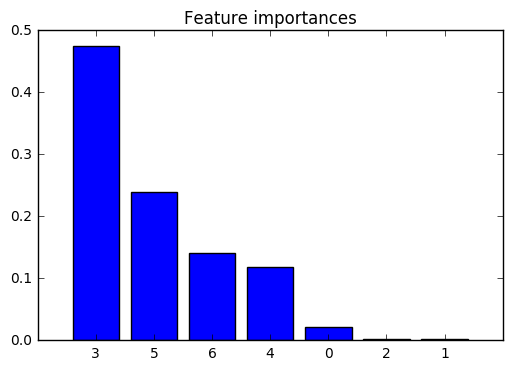

In [99]:
#See features importance
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(trainArr.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainArr.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(trainArr.shape[1]), indices)
plt.xlim([-1, trainArr.shape[1]])
plt.show()

redCountry, Games, Position, and redNum are the most important features. We could therefore drop some features already, such as fraction yellow and fraction yellowRed & fraction Red. Let us delete all cards and see if we can better predict this. 

In [110]:
#make necessary changes to parameters
exclude2 = ['raterScale','mean_rater', 'playerShort', 'fractionYellowRed', 'fractionRed', 'fractionYellow']
exclude3 = ['raterScale','mean_rater', 'playerShort', 'fractionYellowRed', 'fractionRed', 'fractionYellow', 'predictions', 'predictions2']
Input_Data_Training2 = Data_Training.drop(exclude2, axis=1)
trainArr2 = Input_Data_Training2.as_matrix() #training array
trainRes_2 = Data_Training['raterScale'].values


Input_Data_Testing2 = Data_Testing.drop(exclude3, axis=1)
testArr2 = Input_Data_Testing2.as_matrix()

testArr2

array([[2831,  108,    3,    7],
       [ 177,    1,    8,   11],
       [ 194,   44,   13,    7],
       ..., 
       [1745,   48,    5,    6],
       [1214,   44,   27,    6],
       [1814,    3,    4,    9]])

In [111]:
#Re-Initialize Classifier
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data and create the decision trees
forest = forest.fit(trainArr2,trainRes_2)

# Take the same decision trees and run it on the test data
results2 = forest.predict(testArr2)

Data_Testing['predictions2'] = results2
Data_Testing.head()

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater,raterScale,predictions,predictions2
343864,du-ri-cha,0.000000,0.0,0.0,2831,108,3,7,0.375,8,8,8
19739,nikos-karabelas,0.000000,0.0,0.0,177,1,8,11,0.000,1,1,1
23570,tony-hibbert,0.076923,0.0,0.0,194,44,13,7,0.000,1,1,1
297370,zoltan-gera,0.000000,0.0,0.0,2389,44,12,5,0.250,6,6,6
252063,javi-varas,0.000000,0.0,0.0,2063,3,4,3,0.250,6,6,6


In [112]:
#see percentage of right predictions
correct = list(Data_Testing[Data_Testing['raterScale'] == Data_Testing['predictions2']].index)
A = len(correct)
percCorrect = A/Data_Testing['raterScale'].size
percCorrect

0.6727042485985032

Accuracy goes down to 67.3% from changing the input parameters...

Feature ranking:
1. feature 0 (0.536486)
2. feature 2 (0.260748)
3. feature 1 (0.108038)
4. feature 3 (0.094728)


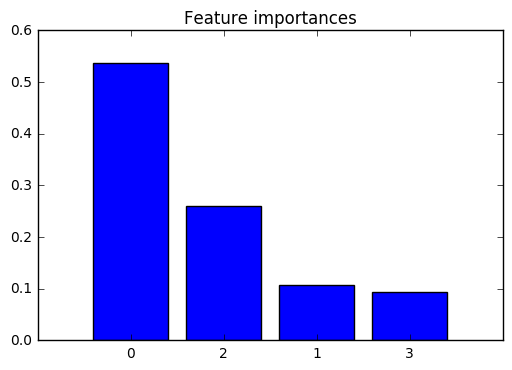

In [113]:
#See features importance
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(trainArr2.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(trainArr2.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(trainArr2.shape[1]), indices)
plt.xlim([-1, trainArr2.shape[1]])
plt.show()

The most important feature in this case is refNum, games, refCountry, position_proxy

Alternatively we can see what happens when we only use the number of cards...

In [153]:
exclude4 = ['raterScale','mean_rater', 'playerShort', 'refNum', 'refCountry', 'games', 'position_proxy']
exclude5 = ['raterScale','mean_rater', 'playerShort', 'refNum', 'refCountry', 'games', 'position_proxy', 'predictions', 'predictions2']
Input_Data_Training3 = Data_Training.drop(exclude4, axis=1)
trainArr3 = Input_Data_Training3.as_matrix() #training array
trainRes_3 = Data_Training['raterScale'].values


Input_Data_Testing3 = Data_Testing.drop(exclude5, axis=1)
testArr3 = Input_Data_Testing3.as_matrix()

testArr3

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.07692308,  0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [154]:
#Re-Initialize Classifier
forest = RandomForestClassifier(n_estimators = 100)

# Fit the training data and create the decision trees
forest = forest.fit(trainArr3,trainRes_3)

# Take the same decision trees and run it on the test data
results3 = forest.predict(testArr3)

Data_Testing['predictions3'] = results3
Data_Testing.head()

,playerShort,fractionYellow,fractionYellowRed,fractionRed,refNum,refCountry,games,position_proxy,mean_rater,raterScale,predictions,predictions2,predictions3
343864,du-ri-cha,0.000000,0.0,0.0,2831,108,3,7,0.375,8,8,8,6
19739,nikos-karabelas,0.000000,0.0,0.0,177,1,8,11,0.000,1,1,1,6
23570,tony-hibbert,0.076923,0.0,0.0,194,44,13,7,0.000,1,1,1,6
297370,zoltan-gera,0.000000,0.0,0.0,2389,44,12,5,0.250,6,6,6,6
252063,javi-varas,0.000000,0.0,0.0,2063,3,4,3,0.250,6,6,6,6


In [155]:
#see percentage of right predictions
correct = list(Data_Testing[Data_Testing['raterScale'] == Data_Testing['predictions3']].index)
A = len(correct)
percCorrect = A/Data_Testing['raterScale'].size
percCorrect

0.3219316467943428

The percentage of correct ratings drops to 32%...

BONUS Question: We can try to analyze accuracy across the scale for the three cases above and see if there is bias in any extreme

In [156]:
# Curve for Test 1 - all variables
Test1 = [];
for i in range (0,20):
    count = list(Data_Testing[Data_Testing['predictions']==i].index)
    A = len(count)
    Test1.append(A)
# Curve for Test 2 - exclude card variables
Test2 = [];
for i in range (0,20):
    count2 = list(Data_Testing[Data_Testing['predictions2']==i].index)
    B = len(count2)
    Test2.append(B)
# Curve for Test 3 - only card variables
Test3 = [];
for i in range (0,20):
    count3 = list(Data_Testing[Data_Testing['predictions3']==i].index)
    C = len(count3)
    Test3.append(C)
# Real Curve
Test4 = [];
for i in range (0,20):
    count4 = list(Data_Testing[Data_Testing['raterScale']==i].index)
    D = len(count4)
    Test4.append(D)


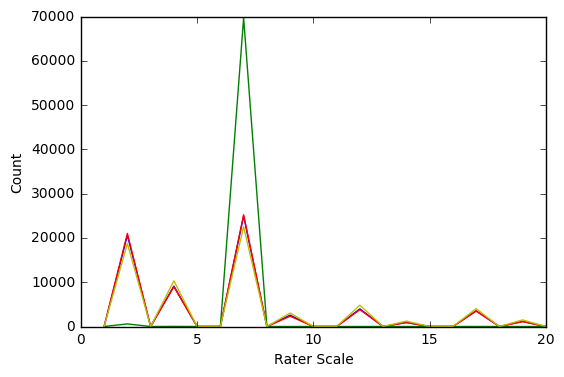

In [167]:
import matplotlib.patches as mpatches

X = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20];
T1 = plt.plot(X, Test1,'b')
T2 = plt.plot(X, Test2, 'r')
T3 = plt.plot(X, Test3, 'g')
T4 = plt.plot(X, Test4, 'y')

plt.ylabel('Count')
plt.xlabel('Rater Scale')
plt.show()

The first two models slightly overestimate number of players on the lower end of the scale, while slightly underestimating players on the middle and higher end. Conversely, when using only card numbers, there is a huge bias around the 6-7 values, with a significant overshoot, while completely underestimating other values. 